# Exploratory Data Analysis of ATP World Tour Match Results


## Importing and Joining the Data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
UseGitHub = True # True
if UseGitHub:
    prefix = 'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/'
else:
    prefix = '' # load locally

In [0]:
# concatenate data from all years (1968-2020), testing on smaller datasets for now
start_year = 1970   # first couple of years are weird
end_year = 2019

all_data = []
for year in range(start_year, end_year + 1):
    csv_for_year = f'{prefix}atp_matches_{year}.csv'
    year_data = pd.read_csv(csv_for_year)
    year_data['year'] = year    # for convenience
    all_data.append(year_data)

df = pd.concat(all_data)
df.reset_index()
df.head();

Add columns for the date

In [0]:
df['year'] = df['tourney_date'].apply(lambda s: int(str(s)[:4]))
df['month'] = df['tourney_date'].apply(lambda s: int(str(s)[4:6]))
df['day'] = df['tourney_date'].apply(lambda s: int(str(s)[6:]))
df.head();

Add a match status column for easier querying later on.

In [0]:
def completed(score, best_of):
  if not isinstance(score, str):
    # print(score)
    return 'unscored'

  tennis_sets = score.split()
  l_sets = 0
  r_sets = 0

  for tennis_set in tennis_sets:
    if 'RET' in score or 'W/O' in score or 'DEF' in score or 'Default' in score:
      return 'retired'
    if 'In progress' in tennis_set or 'Unfinished' in tennis_set or 'Played' in tennis_set:
      return 'incomplete'

    score, *rem = tennis_set.split('(')

    # weird edge cases will be filtered out
    try:
      l, r = score.split('-')
    except:
      # print(score)
      return 'invalid'

    if not l.isdigit() or not r.isdigit():
      return 'invalid'

    l, r = int(l), int(r)
    if abs(l - r) >= 2 and (l >= 6 or r >= 6):
      if l > r:   l_sets += 1
      else:       r_sets += 1
      continue
    elif abs(l - r) == 1 and l in {6, 7} and r in {6, 7} and rem:
      if l > r:   l_sets += 1
      else:       r_sets += 1
      continue
    # return 'retired'

  if l_sets > (best_of + 1) // 2 or r_sets > (best_of + 1) // 2:
    return 'invalid'
  
  if l_sets > r_sets:
    if l_sets == (best_of + 1) // 2:
      return 'complete'
    return 'incomplete'

  if r_sets == (best_of + 1) // 2:
    return 'complete'
  return 'incomplete'


df['status'] = df[['score', 'best_of']].apply(lambda x: completed(*x), axis=1)
df.head();

In [0]:
print("complete:   ", df[df['status'] == 'complete'].size)
print("incomplete: ", df[df['status'] == 'incomplete'].size)    # could be further processed 
print("retired:    ", df[df['status'] == 'retired'].size)
print("invalid:    ", df[df['status'] == 'invalid'].size)
print("unscored:   ", df[df['status'] == 'unscored'].size)

complete:    8061512
incomplete:  848106
retired:     236062
invalid:     9911
unscored:    7579


Clean the data of improper tennis scores before continuing.

In [0]:
df = df[df['status'] != 'invalid']

### Question 1: What is the likelihood of a player winning the match after losing the first set in a best of three sets tennis match? After losing the first two sets in a best of five sets tennis match? This analysis excludes matches ended by retirement.

Divide the dataset into 3-set and 5-set matches, removing any matches that were not completed.

In [0]:
df_3set = df[(df['best_of'] == 3) & (df['status'] == 'complete')]
df_5set = df[(df['best_of'] == 5) & (df['status'] == 'complete')]
df_other = df[(df['best_of'] != 3) & (df['best_of'] != 5) & (df['status'] == 'complete')]
#print(df["score"].head())

In [0]:
# determine if the set is a win or loss
def set_win_or_loss(set_score):
  games_lst = set_score.split("-")

  # remove any tiebreak score to do comparison on number of games won
  games_lst = [x[:(x.find('('))] if x.find('(') != -1 else x for x in games_lst]
  try:
    p1_games, p2_games = games_lst
  except:
    return "l"
  if int(p1_games) > int(p2_games):
    return "w"
  elif int(p1_games) < int(p2_games):
    return "l"

print("Testing 'set_win_or_loss' ... ", end="")
assert(set_win_or_loss("7-6(5)"), 'w')
print('passed!')


# determine if the match was won after losing the first one or two sets
def ultimate_comeback(match_score, best_of):
  set_scores = match_score.split(" ")
  set_scores_wl = [set_win_or_loss(set_score) for set_score in set_scores]
  #print(set_scores_wl)

  # if best of 3 sets
  if best_of == 3:
    first, *_ = set_scores_wl
    if first == "l":      # loser of first set won match
      return "yes"
    elif first == "w":    # loser of first set lost match 
      return "no"

  # if best of 5 sets
  elif best_of == 5:
    first, second, *_ = set_scores_wl
    if first == "l" and second == "l":    # loser of first two won match
      return "yes"
    elif first == "w" and second == "w":  # loser of first two lost match 
      return "no"

  # first set not lost for best of 3 sets
  # or first two sets not lost for best of 5 sets
  return "other"


# Testing ultimate_comeback
print("Testing 'ultimate_comeback' ... ", end="")
assert(ultimate_comeback("7-6(5) 4-6 7-5", 3), 'no')
assert(ultimate_comeback("6-7(5) 6-3 6-4 5-7 7-6(1)", 5), 'no')
assert(ultimate_comeback("6-7(5) 6-4 7-5", 3), 'yes')
assert(ultimate_comeback("6-7(5) 3-6 6-4 7-5 7-6(1)", 5), 'yes')
print("passed!")

Testing 'set_win_or_loss' ... passed!
Testing 'ultimate_comeback' ... passed!


Aggregation helper

In [0]:
def yes_no_agg(df, comeback_f):
  yes_or_no = df[['score', 'best_of']].apply(lambda x: comeback_f(*x), axis=1)
  yes_or_no = yes_or_no[yes_or_no.values != 'other']
  counts = yes_or_no.value_counts().sort_index()
  counts = counts/(counts.sum())
  ax = counts.plot(kind='bar')
  ax.set_xlabel("Win Success")
  ax.set_ylabel("Probability")
  return counts, ax

We can then see how often a person wins a 3-set match after losing the first set.

Probability of winning a best of 3 sets match after losing the first set: 0.17777907471173326


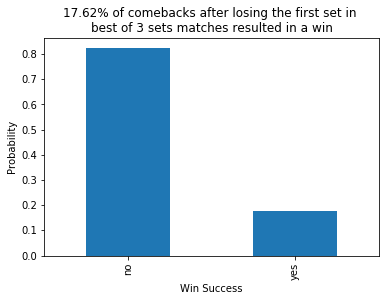

In [0]:
set_counts, ax = yes_no_agg(df_3set, ultimate_comeback)
print("Probability of winning a best of 3 sets match after losing the first set: " \
        + str(set_counts["yes"]/(set_counts["yes"] + set_counts["no"])))
ax.set_title("17.62% of comebacks after losing the first set in \n" +
             "best of 3 sets matches resulted in a win")
ax

For 3-set matches, a comeback happens moderately often, around 17.6 percent of the time (depending on the exact start and end years queried from Github). Such a comeback is not really a miracle.

Below we see the probability of winning a best of 5 sets match after losing the first two sets.

Probability of winning a best of 5 sets match after losing the first two sets: 0.05820909258236702


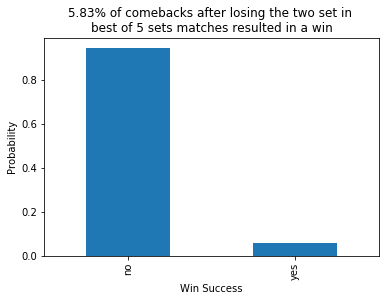

In [0]:
set_counts, ax = yes_no_agg(df_5set, ultimate_comeback)
print("Probability of winning a best of 5 sets match after losing the first two sets: " \
      + str(set_counts["yes"]/(set_counts["yes"] + set_counts["no"])))
ax.set_title("5.83% of comebacks after losing the two set in \n" +
             "best of 5 sets matches resulted in a win")
ax

As demonstrated by the bar charts and as expected, it is much more difficult to comeback after going down two sets in a best of 5 sets match compared to going down one set in a best of 3 sets match. This could be explained by the fact that if a player is able to win two sets  against an opponent, they are likely better in terms of skill. Also, better players are unlikely to lose two two sets in a row, which reduces the number of potential and actual comebacks.

In both of these analyses, matches from all levels of professional tennis competition are included. How does the probability change for only Grand Slam matches (the four highest level tournaments), where the stakes are higher? Grand Slams are all best of 5 sets.

Probability of winning a best of 3 sets match after losing the first set in Grand Slams: 0.05994897959183673


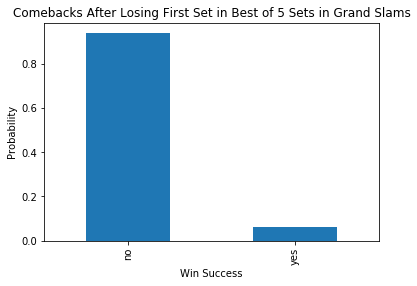

In [0]:
df_5set_slams = df_5set[df_5set["tourney_level"]=="G"]
set_counts, ax = yes_no_agg(df_5set_slams, ultimate_comeback)
print("Probability of winning a best of 3 sets match after losing the first set in Grand Slams: " \
        + str(set_counts["yes"]/(set_counts["yes"] + set_counts["no"])))
ax.set_title("Comebacks After Losing First Set in Best of 5 Sets in Grand Slams")
ax

Below we combine the graphs for best of 5 set matches for tournaments of all levels and for Grand Slams.

no     7938
yes     466
dtype: int64
no     0.94455
yes    0.05545
Name: Non-Slams, dtype: float64
no     12529
yes      799
dtype: int64
no     0.940051
yes    0.059949
Name: Grand Slams, dtype: float64


Text(0, 0.5, 'Win Percentage')

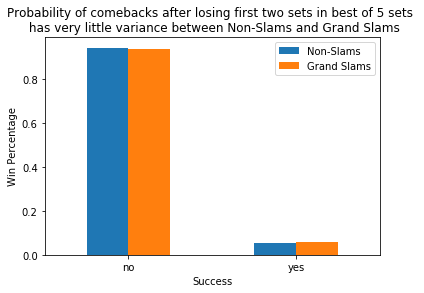

In [0]:
df_5set_nonSlams = df_5set[df_5set["tourney_level"]!="G"]
yes_or_no_nonSlam = df_5set_nonSlams[['score', 'best_of']].apply(lambda x: ultimate_comeback(*x), axis=1)
yes_or_no_nonSlam = yes_or_no_nonSlam[yes_or_no_nonSlam.values != 'other']
counts_nonSlam = yes_or_no_nonSlam.value_counts().sort_index()
print(counts_nonSlam)
counts_nonSlam = counts_nonSlam.divide(counts_nonSlam.sum(), fill_value=0)
counts_nonSlam = counts_nonSlam.rename("Non-Slams")
print(counts_nonSlam)

yes_or_no_slam = df_5set_slams[['score', 'best_of']].apply(lambda x: ultimate_comeback(*x), axis=1)
yes_or_no_slam = yes_or_no_slam[yes_or_no_slam.values != 'other']
counts_slam = yes_or_no_slam.value_counts().sort_index()
print(counts_slam)
counts_slam = counts_slam.divide(counts_slam.sum(), fill_value=0)
counts_slam = counts_slam.rename("Grand Slams")
print(counts_slam)

result = pd.concat([counts_nonSlam, counts_slam], axis=1)
result.head()

ax = result.plot.bar(rot=0)
ax.set_title("Probability of comebacks after losing first two sets in best of" +
             " 5 sets \n has very little variance between Non-Slams and Grand Slams")
ax.set_xlabel("Success")
ax.set_ylabel("Win Percentage")

Compared to non-slams, there is a 0.465% greater probability of winning a best of 5 sets match in a Grand Slam after losing the first two sets, which is a 10% change in probability. Although there is a small relative difference in probability, it doesn't amount to much of a difference.

### Question 2: Does the number of aces from the winner relative to the number of aces from the loser in a match correlate to a greater likelihood to win the match?

Let's first take a look at the service ace distribution of winners.

Probability of winning the match with a zero or positive ace differential: 0.6776043364359615


Text(0.5, 1.0, 'Winners historically have a 67.9% probability of winning the\n match if they have a zero or positive ace differential')

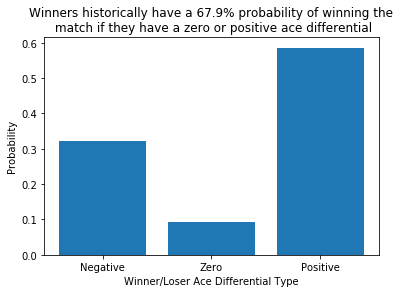

In [0]:
df_tmp = df[df['status'] == 'complete']
df_completed = df_tmp.dropna(subset=['w_ace', 'l_ace'])

winner_aces = df_completed["w_ace"]
loser_aces = df_completed["l_ace"]

w_ace_diff = winner_aces.subtract(loser_aces).sort_values()

neg_diff = (w_ace_diff[w_ace_diff < 0]).count()
zero_diff = (w_ace_diff[w_ace_diff == 0]).count()
pos_diff = (w_ace_diff[w_ace_diff > 0]).count()

total = neg_diff + zero_diff + pos_diff
neg_diff_prob = neg_diff/total
zero_diff_prob = zero_diff/total
pos_diff_prob = pos_diff/total

zero_or_pos_prob = zero_diff_prob + pos_diff_prob

print("Probability of winning the match with a zero or positive ace differential: " + str(zero_or_pos_prob))

names = ["Negative", "Zero", "Positive"]
values = [neg_diff_prob, zero_diff_prob, pos_diff_prob]
plt.bar(names, values)
plt.xlabel('Winner/Loser Ace Differential Type')
plt.ylabel('Probability')
plt.title('Winners historically have a 67.9% probability of winning the\n match' +
          " if they have a zero or positive ace differential")

Of all match winners, 67.76% of them serve at least as many aces as their opponent. Such players are often more than their opponents, so this statistic doesn't say much about how serving actually contributes to winning a match. Still serving better does account for some effect. 

It might be more informative to determine what actually contributes to better serving. One such factor is height, since specific players like John Isner serve well. How much does player height impact the number of service points that are aces?

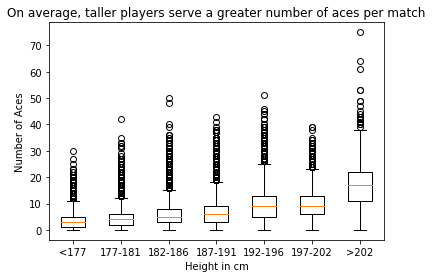

In [0]:
# group players into several buckets by height
df_leq176 = df_completed[(df_completed['winner_ht'] <= 176)].dropna(subset=['w_ace','w_svpt'])
df_177to181 = df_completed[(df_completed['winner_ht'] > 176) & (df_completed['winner_ht'] <= 181)].dropna(subset=['w_ace','w_svpt'])
df_182to186 = df_completed[(df_completed['winner_ht'] > 181) & (df_completed['winner_ht'] <= 186)].dropna(subset=['w_ace','w_svpt'])
df_187to191 = df_completed[(df_completed['winner_ht'] > 186) & (df_completed['winner_ht'] <= 191)].dropna(subset=['w_ace','w_svpt'])
df_192to196 = df_completed[(df_completed['winner_ht'] > 191) & (df_completed['winner_ht'] <= 196)].dropna(subset=['w_ace','w_svpt'])
df_197to202 = df_completed[(df_completed['winner_ht'] > 196) & (df_completed['winner_ht'] <= 202)].dropna(subset=['w_ace','w_svpt'])
df_geq203 = df_completed[(df_completed['winner_ht'] > 202)].dropna(subset=['w_ace','w_svpt'])

group_leq176_ace = df_leq176['w_ace']#.dropna()
group_177to181_ace = df_177to181['w_ace']#.dropna()
group_182to186_ace = df_182to186['w_ace']#.dropna()
group_187to191_ace = df_187to191['w_ace']#.dropna()
group_192to196_ace = df_192to196['w_ace']#.dropna()
group_197to202_ace = df_197to202['w_ace']#.dropna()
df_geq203_tmp = df_geq203[df_geq203['w_ace'] != 113] # removing extreme outlier
group_geq203_ace = df_geq203_tmp['w_ace']#.dropna()

groups = ['<177', '177-181','182-186','187-191','192-196','197-202','>202']

data = [group_leq176_ace,group_177to181_ace,group_182to186_ace,
           group_187to191_ace,group_192to196_ace,group_197to202_ace,
           group_geq203_ace]

fig3, ax3 = plt.subplots()
ax3.set_title("On average, taller players serve a greater number of aces per match")
ax3.set_xlabel("Height in cm")
ax3.set_ylabel("Number of Aces")
ax3.set_xticklabels(groups)
ax3.boxplot(data)
plt.show()

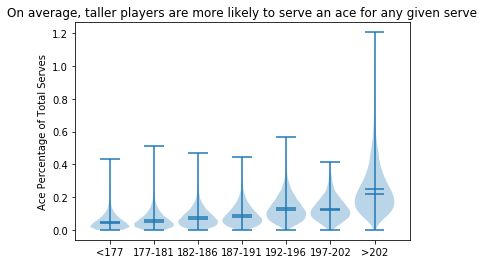

In [0]:
group_leq176_ace = group_leq176_ace.divide(df_leq176['w_svpt'])
group_177to181_ace = group_177to181_ace.divide(df_177to181['w_svpt'])
group_182to186_ace = group_182to186_ace.divide(df_182to186['w_svpt'])
group_187to191_ace = group_187to191_ace.divide(df_187to191['w_svpt'])
group_192to196_ace = group_192to196_ace.divide(df_192to196['w_svpt'])
group_197to202_ace = group_197to202_ace.divide(df_197to202['w_svpt'])
group_geq203_ace = group_geq203_ace.divide(df_leq176['w_svpt']).dropna()


pos = [1, 2, 3, 4, 5, 6, 7]
data = [group_leq176_ace,group_177to181_ace,group_182to186_ace,
           group_187to191_ace,group_192to196_ace,group_197to202_ace,
           group_geq203_ace]
data = [l.tolist() for l in data]

plt.violinplot(data, pos, widths=0.9, showmeans=True, showextrema=True, showmedians=True)
plt.title("On average, taller players are more likely to serve an ace for any given serve")
plt.xticks(range(1, len(groups) + 1), groups)
plt.ylabel("Ace Percentage of Total Serves")
plt.savefig('Violin_Aces')

The Box and Whiskers plot demonstrates that taller players tend to serve a greater number of aces per match, on average, However, this could hypothetically be due to taller players playing longer matches, and thus they serve more aces simply because they need to serve more times. The violin plot shows the same results, though it also shows that the number of aces in a match is skewed toward greater number of aces.



We will next analyze height compared to the ratio of aces to total service points to determine if height is correlated to a greater percentage of aces amongst a player's total service points.

In [0]:
cleaned_df_completed = df_completed.dropna(subset=['winner_ht', 'w_ace'])
height = cleaned_df_completed['winner_ht']
ratio_aces = cleaned_df_completed['w_ace'].divide(cleaned_df_completed['w_svpt'])

pearson = np.corrcoef(height,ratio_aces)[1,0]
print("Pearson Correlation Coefficient: "+ str(pearson))

Pearson Correlation Coefficient: 0.41939856114768925


The Pearson Correlation Coefficient between height and number of aces to total serves per match is 0.419, which indicates a moderate positive linear correlation. Thus, we can generally say that taller players hit more aces relative to their total service points in addition to hitting more aces per match.

### Question 3: How much has mid-match retirement or pre-match withdrawal rate changed?


Retirement from matches has increased as of late, so we should see that easily from the data with a graph of retirements per match in a given year.

We start by making a new dataframe for just match retirements.

In [0]:
print(df[df['status'] == 'complete'].size)
print(df[df['status'] == 'incomplete'].size)
print(df[df['status'] == 'retired'].size)

# need to create column of whether a player retired early or finished a match
retired_df = df[df['status'] == 'retired']
retired_df.head();

8061512
848106
236062


Let's see how the retirement rate has changed over time.

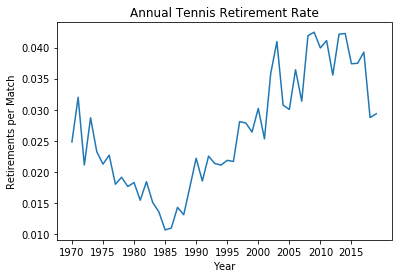

In [0]:
retirements_per_year = retired_df.groupby(['year']).size()
matches_per_year = df.groupby(['year']).size()

plt.plot(matches_per_year.index, retirements_per_year / matches_per_year)
plt.title('Annual Tennis Retirement Rate')
plt.xlabel('Year')
plt.xticks(np.arange(matches_per_year.index.min(), matches_per_year.index.max()+1, 5.0))
plt.ylabel('Retirements per Match')
plt.savefig('Retirements_per_Match')

We can see that retirements rise over time, which is somewhat troubling. Players that retire for other reasons could experience a fine and a lower rankings, which could prevent them from competing in lucrative tournaments. Therefore, tennis players in general only retire or withdraw from matches due to exhaustion or injury.

Age is definitely a concern, judging from the graph below.

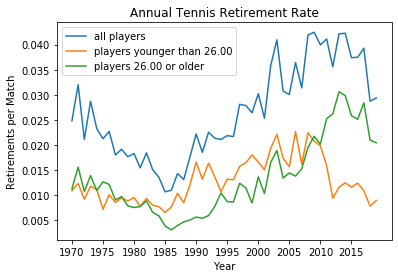

In [0]:
avg_retired_loser = retired_df['loser_age'].median()
retirements_young_per_year = retired_df[retired_df['loser_age'] < avg_retired_loser].groupby(['year']).size()
retirements_per_year = retired_df.groupby(['year']).size()
retirements_old_per_year = retired_df[retired_df['loser_age'] >= avg_retired_loser].groupby(['year']).size()
matches_per_year = df.groupby(['year']).size()

p1, = plt.plot(matches_per_year.index, retirements_per_year / matches_per_year)
p1.set_label("all players")
p2, = plt.plot(matches_per_year.index, retirements_young_per_year / matches_per_year)
p2.set_label("players younger than %0.2f" % avg_retired_loser)
p3, = plt.plot(matches_per_year.index, retirements_old_per_year / matches_per_year)
p3.set_label("players %0.2f or older" % avg_retired_loser)
plt.title('Annual Tennis Retirement Rate')
plt.xlabel('Year')
plt.xticks(np.arange(matches_per_year.index.min(), matches_per_year.index.max()+1, 5.0))
plt.ylabel('Retirements per Match')
plt.legend()
plt.savefig('Retirement_Rate_Age_Splits')

Younger players were more likely to retire when retirements were least common (in the 1980s). The rise in retirements has come largely from players that are older, denoted by the green line. In context, that's about 2.5 retirements from older players at a single major championship event. Over the past decade, players that retire are twice as likely to be above the historical median retirement age than below. Given improvements in nutrition and injury management, that older players sitll retire so often is a major (pun somewhat intended) concern.

Another potential factor for retirement rate is annual match count. Is match count a concern?

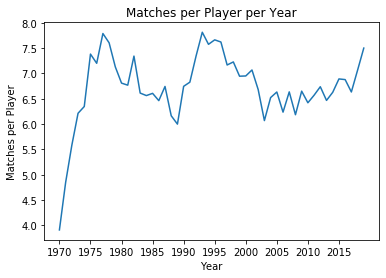

In [0]:
def f(x):
  winners = x.groupby(by='winner_id').size().to_frame('wins')
  losers  = x.groupby(by='loser_id').size().to_frame('losses')
  players = pd.concat([winners, losers], axis=1).index
  unique_players = set(players.tolist())
  return len(unique_players.intersection(relevant_players))

def plot_matches_per_player(relevant_players):
  players_by_year = df.groupby(by='year').apply(f)
  matches_by_year = df.groupby(by='year').count()
  plt.plot(matches_per_year.index, matches_per_year / players_by_year)
  plt.title('Matches per Player per Year')
  plt.xlabel('Year')
  plt.xticks(np.arange(matches_per_year.index.min(), matches_per_year.index.max()+1, 5.0))
  plt.ylabel('Matches per Player')

winners = df.groupby(by='winner_id').size().to_frame('wins')
losers  = df.groupby(by='loser_id').size().to_frame('losses')
players = pd.concat([winners, losers], axis=1)
players['matches'] = players['wins'] + players['losses']
relevant_players = set(players.index.tolist())
plot_matches_per_player(relevant_players)
plt.savefig('Annual_Match_Count_Splits')

While the rise in match count in the past 10 years of data is concerning, it doesn't fully explain the consistent rise in retirement rate ... or so you think. As it turns out, the data contains a lot of noise from players that don't play many matches. Let's see happens when you filter out players that have played fewer than 20 matches on tour (for context, an average player will play at least 20 matches a year, and some might even play more than 60 matches in a single year).

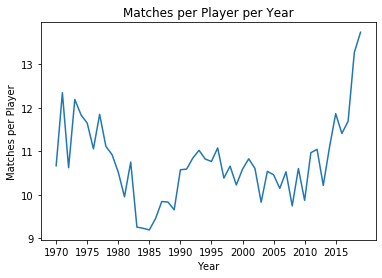

In [0]:
relevant_players = set(players[players['matches'] >= 20].index.tolist())
plot_matches_per_player(relevant_players)
plt.savefig('Annual_Match_Count_20_Splits')

The trend is much more pronounced here; players with only a couple of matches on tour in their entire career are much more unlikely to retire than players who have played several years and accumulated minor injuries and muscle fatigue.

The plot below shows that the trend of match count was hidden by the noise until the noise was removed.

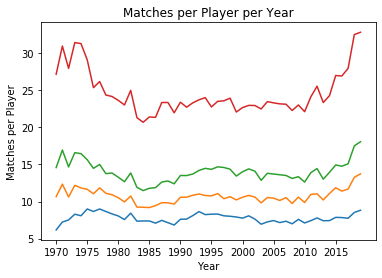

In [0]:
for num in [0, 20, 50, 200]:    # match count minimums
  relevant_players = set(players[players['matches'] >= num].index.tolist())
  plot_matches_per_player(relevant_players)
plt.savefig('Annual_Match_Counts_Reduce_Noise_Splits')

Match retirements also have some relationship with the number of years a player has played at a high professional level. Among players with at least 20 matches played, the average number of years spent on tour has increased slightly, by 2 years.

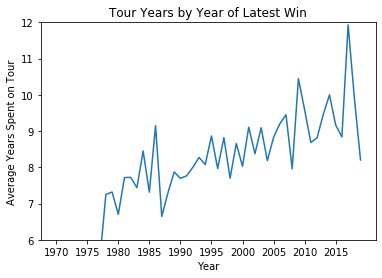

In [0]:
relevant_players = set(players[players['matches'] >= 20].index.tolist())
win_groups = df[df['winner_id'].isin(relevant_players)].groupby(by='winner_id')
winners = win_groups.apply(lambda x: x['year'].max() - x['year'].min()).to_frame('years')
firsts = win_groups.apply(lambda x: x['year'].min()).to_frame('first')
lasts = win_groups.apply(lambda x: x['year'].max()).to_frame('last')
all_players = pd.concat([winners, firsts, lasts], axis=1)

tour_averages = all_players.groupby(by='last').mean()['years']
plt.plot(tour_averages.index, tour_averages)
plt.title('Tour Years by Year of Latest Win')
plt.xlabel('Year')
plt.xticks(np.arange(matches_per_year.index.min(), matches_per_year.index.max()+1, 5.0))
plt.ylabel('Average Years Spent on Tour')
plt.ylim(6, 12)
plt.savefig('Tour_Years')

To protect its players, the professional tennis association (ATP) should reduce mandatory playing minimums and give more rest between tournaments. Also, older players and veteran players should be monitored for fatigue and accumulated minor injuries.

### Question 4: Within a group of players with similar match win/loss ratio, who performs better during the four majors (largest tournaments)? How much do stakes matter?

Let's first select matches that were played during the four majors (Australian Open, French Open, Wimbledon, and US Open).

In [0]:
df[df['tourney_name'] == 'Australian Open'].head();
df[df['tourney_name'] == 'Wimbledon'].head();
df[df['tourney_name'] == 'US Open'].head();
df[df['tourney_name'] == 'Roland Garros'].head();

In [0]:
nonmajor_matches = df[(df['tourney_name'] != 'Australian Open') \
   & (df['tourney_name'] != 'Wimbledon') \
   & (df['tourney_name'] != 'US Open') \
   & (df['tourney_name'] != 'Roland Garros')]

major_matches = df[(df['tourney_name'] == 'Australian Open') \
   | (df['tourney_name'] == 'Wimbledon') \
   | (df['tourney_name'] == 'US Open') \
   | (df['tourney_name'] == 'Roland Garros')]

We can then start grouping by player.

In [0]:
def group_by_player(matches, win_colname, loss_colname, rate_colname):
  winners = matches.groupby(by='winner_id').size().to_frame(win_colname)
  losers  = matches.groupby(by='loser_id').size().to_frame(loss_colname)
  players = pd.concat([winners, losers], axis=1)
  players[rate_colname] = players[win_colname] / players[loss_colname]
  return players

nonmajor_players = group_by_player(nonmajor_matches, 'nonmajor_wins', 'nonmajor_losses', 'nonmajor_win_rate')
major_players = group_by_player(major_matches, 'major_wins', 'major_losses', 'major_win_rate')
# nonmajor_players.sort_values('nonmajor_win_rate', ascending=False)
# major_players.sort_values('major_win_rate', ascending=False);

In [0]:
def combine(nonmajor_players, major_players):
  players = pd.concat([nonmajor_players, major_players], axis=1)
  players = players[players['nonmajor_wins'] + players['nonmajor_losses'] > 20]
  players = players[players['major_wins'] + players['major_losses'] > 10]
  return players

relevant_players = combine(nonmajor_players, major_players)
relevant_players.head();

Let's take a look at how players perform differently between major competitions and nonmajor competitions.

In [0]:
def plot_win_rates(p, x_max):
  plt.scatter(p['nonmajor_win_rate'], p['major_win_rate'], s=10)
  plt.title('Win Rate Comparison')
  plt.xlabel('Non-Major Win Rate')
  plt.ylabel('Major Win Rate')
  plt.gca().set_aspect('equal', adjustable='box')

  x = np.linspace(0, x_max)
  line1, = plt.plot(x, x, "orange")

  m, b = np.polyfit(p['nonmajor_win_rate'], p['major_win_rate'], 1)
  print(m, b)
  lr_x = np.linspace(0, x_max)
  lr_y = m*lr_x + b
  line2, = plt.plot(lr_x, lr_y, "g--")

  line1.set_label('y = x')
  line2.set_label('linear regression')

  plt.ylim(0, 7)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

1.2471346251893334 -0.2989393807976144


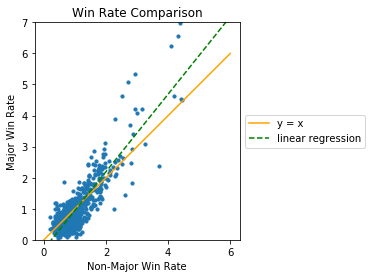

In [0]:
plot_win_rates(relevant_players, 6)
plt.savefig('All Win Rates')

We can see a positive relationship between the two win rates: people that win outside of grand slam matches also tend to win grand slam matches.

Finally, let's filter out matches such that group players have similar win rates, dividing them into 5 win rate groups. The divides were chosen arbitrarily: group 1 contains players we expect to win tournaments, group 2 contains players we expect to to play into the second or thrid round, and so on down to group 5 which contains players that lose often.

In [0]:
group1 = relevant_players[relevant_players['nonmajor_win_rate'] > 2]
group2 = relevant_players[(relevant_players['nonmajor_win_rate'] <= 2) & (relevant_players['nonmajor_win_rate'] > 6/5)]
group3 = relevant_players[(relevant_players['nonmajor_win_rate'] <= 6/5) & (relevant_players['nonmajor_win_rate'] >= 5/6)]
group4 = relevant_players[(relevant_players['nonmajor_win_rate'] < 5/6) & (relevant_players['nonmajor_win_rate'] >= 1/2)]
group5 = relevant_players[relevant_players['nonmajor_win_rate'] < 1/2]
print("Group 1 size: %d" % group1.size)
print("Group 2 size: %d" % group2.size)
print("Group 3 size: %d" % group3.size)
print("Group 4 size: %d" % group4.size)
print("Group 5 size: %d" % group5.size)

Group 1 size: 240
Group 2 size: 906
Group 3 size: 1692
Group 4 size: 2298
Group 5 size: 486


We can already see that most players tend to lose more than they win, which suggests that tennis favorites in group 1 tend to dominate their lower competition.

Let's now start selecting matches between players in the same group to control (somewhat) for skill level and winning tendencies.

In [0]:
def major_nonmajor_comp(group, x_max):
  group_major_matches = major_matches[(major_matches['winner_id'].isin(group.index)) & (major_matches['loser_id'].isin(group.index))]
  group_nonmajor_matches = nonmajor_matches[(nonmajor_matches['winner_id'].isin(group.index)) & (nonmajor_matches['loser_id'].isin(group.index))]

  group_nonmajor = group_by_player(group_nonmajor_matches, 'nonmajor_wins', 'nonmajor_losses', 'nonmajor_win_rate')
  group_major = group_by_player(group_major_matches, 'major_wins', 'major_losses', 'major_win_rate')
  relevant_players_group = combine(group_nonmajor, group_major)
  plot_win_rates(relevant_players_group, x_max)

1.5081841312511033 -0.40868076533814035


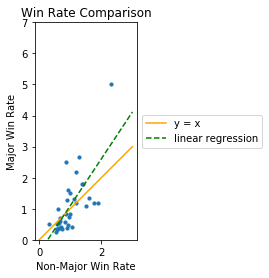

In [0]:
major_nonmajor_comp(group1, 3)
plt.savefig('Group 1 Win Rate Comparison')

0.8796939911859872 0.24774636898361993


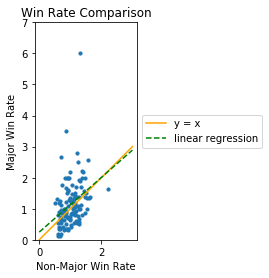

In [0]:
major_nonmajor_comp(group2, 3)
plt.savefig('Group 2 Win Rate Comparison')

0.5769359346710798 0.5778796280449384


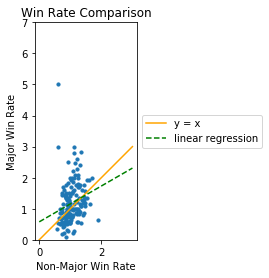

In [0]:
major_nonmajor_comp(group3, 3)
plt.savefig('Group 3 Win Rate Comparison')

0.3565587969166229 1.164839481639199


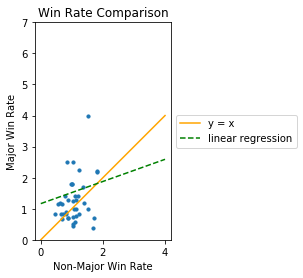

In [0]:
major_nonmajor_comp(group4, 4)
plt.savefig('Group 4 Win Rate Comparison')

There was no data for matches between members of group 5, which is not surprising. Tennis is based on a bracket seeding system which never pits players with similarly low ranking together in matches. The only way for such players to meet is to play several rounds into the tournament, which is unlikely since multiple such players must perform better than expected.

In [0]:
# Not enough data
# major_nonmajor_comp(group5, 4)

Now that we have grouped the players, we can make two important observations: the linear regression lines have increasing slope starting from group 4 matches up to group 5. Also, group 1 (and even group 2) contains extreme positive outliers. 

What the first trend suggests is that players in lower ranks tend to have similar skill level, hence, there is little correlation between win rate in non-major competitions and win rate in major competitions. As you continue up the player groups, the difference in skill widens. For players with less skill, stakes mean much less since there is so much variance.

However, group 1 and group 2 contain severe outliers. For such players, major competitions mean more than other types of competition. It might be that these players (Federer, Djokovic, Nadal, etc.) are after fame and greatness, since they probably make enough money due to their relative superiority in skill.